# Info
Name:  

    Spectral_retrieval_exmaple

Purpose:  

    Python script to create examples for presentation on the basis of spectral cloud property retrieval from transmitted light. 
    Used for presentation at CU Radiometry workshop, March 2016
  
Input:

    none at command line
  
Output:

    figures and save files...
  
Keywords:

    none
  
Dependencies:

    - Sp_parameters.py : for Sp class definition, and for defining the functions used to build parameters
    - run_kisq_retrieval.py : for the retrieval functions
    - load_utils.py : for loading modis files, and various other loading
    - matplotlib
    - numpy
    - scipy : for saving and reading
    - math
    - os
    - gc
    - pdb
    - plotting_utils (user defined plotting routines)
    - map_utils, dependent on geopy
    - hdf5storage
  
Needed Files:

  - file.rc : for consistent creation of look of matplotlib figures
  - sp_v3_20130913_4STAR.out: modeled spectra output for SEAC4RS at sza 17.9, idl save file
  - %%20130219starzen_rad.mat : special zenith radiance 4star matlab file 
  
Modification History:

    Written: Samuel LeBlanc, NASA Ames, Flight SJC to DEN, 2016-03-07

# Initial Imports and default folders

In [1]:
%config InlineBackend.rc = {}
import matplotlib 
matplotlib.rc_file('C:\\Users\\sleblan2\\Research\\python_codes\\file.rc')
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpltools import color
import numpy as np, h5py
import scipy.io as sio
import math
import os
import Sp_parameters as Sp
import hdf5storage as hs
from load_utils import mat2py_time, toutc, load_ict
from Sp_parameters import smooth
import cPickle as pickle
%matplotlib notebook

C:\Python27_64\WinPython-64bit-2.7.6.4\python-2.7.6.amd64\lib\site-packages\IPython\kernel\__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [4]:
# set the basic directory path
fp='C:/Users/sleblan2/Research/cloud_retrieval/'
fp_in = 'C:/Users/sleblan2/Research/SEAC4RS/'

# Load data and models

## Load the modeled radiance and irradiance data and run the parameters

In [106]:
vv = 'v2'
s = sio.idl.readsav(fp_in+'model\\sp_'+vv+'_20130913_4STAR.out')#fp+'model/sp_v1.1_20130913_4STAR.out')

In [6]:
s.keys()

['tau',
 'ab',
 'pw',
 'sp_irrdn',
 'sp',
 'zenlambda',
 'sza',
 'zout',
 'sp_irrup',
 'z',
 'ref']

In [122]:
s['sp'].shape

(2L, 1556L, 2L, 35L, 22L)

In [124]:
np.any(np.isfinite(s['sp'][1,:,1,:,:]))

True

In [107]:
# create custom key for sorting via wavelength
iwvls = np.argsort(s.zenlambda)
s.wv = np.sort(s.zenlambda)

In [108]:
lut = Sp.Sp(s,irrad=True)
lut.params()
lut.param_hires()

1556 1556
in sp
(2L, 1556L, 2L, 35L, 22L)
in irrad
(2L, 1556L, 2L, 35L, 22L)
Running Parameters
Running parameter hires
(103L,)
(59L,)
Running interpolation on params: [########################################]100% -- Done! 


In [109]:
lut.sp_hires()

(103L,)
(59L,)
Running interpolation: [########################################]100% -- Done! 
Overwriting the current sp, tau, and ref with the new high resolution values


In [110]:
lut.sp_hires(doirrad=True)

(103L,)
(59L,)
Running interpolation: [########################################]100% -- Done! 
Creating reflect spectra with tau, and ref of the new high resolution values


## Load the measured 4STAR data

In [22]:
# load the matlab file containing the measured TCAP radiances
mea = sio.loadmat(fp+'../4STAR/SEAC4RS/20130913/20130913starzen_3.mat')
mea.keys()

['QdVtb',
 'sunel',
 'm_aero',
 'El_deg',
 'visfilen',
 'skyresp',
 'nirAVG',
 'QdVlr',
 'nirheader',
 'sza',
 'Lon',
 'rad',
 'visVdettemp',
 'nirrow_labels',
 'raw',
 'rate',
 'pitch',
 'visrow_labels',
 'Tst',
 'ng',
 'fwhm',
 'program_version',
 'c0err',
 'sat_time',
 'nirt',
 'Tbox',
 'visheader',
 'nirTint',
 'm_H2O',
 'RHprecon_percent',
 'Tprecon',
 'filename',
 'note',
 'O3h',
 'NO2col',
 'm_ray',
 'Headng',
 'Lat',
 '__version__',
 'RH',
 'roll',
 'Pst',
 'aerosolcols',
 'nirsat_pixel',
 'Md',
 'nirVdettemp_C',
 'w',
 'vist',
 'sd_aero_crit',
 'sunaz',
 'dark',
 'AZcorr',
 'aeronetcols',
 'nirVdettemp',
 'Str',
 'Elstep',
 'visAVG',
 'c0',
 'Tprecon_C',
 'visTint',
 'O3col',
 'nircols',
 'Zn',
 'vissat_pixel',
 'AZstep',
 'AZ_deg',
 'nirfilen',
 'darkstd',
 'QdVtot',
 'RHprecon',
 '__header__',
 '__globals__',
 'toggle',
 'rawcorr',
 'sat_ij',
 't',
 'c0mod',
 'ELcorr',
 'skyresperr',
 'Alt',
 'Tbox_C',
 'viscols',
 'f',
 'visVdettemp_C']

In [23]:
print mea['t']
tt = mat2py_time(mea['t'])
mea['utc'] = toutc(tt)

[[ 735490.72298159]
 [ 735490.72299588]
 [ 735490.72301704]
 ..., 
 [ 735490.93319317]
 [ 735490.9332203 ]
 [ 735490.93324598]]


In [24]:
mea['good'] = np.where((mea['utc']>18.5) & (mea['utc']<19.75) & (mea['Str'].flatten()!=0) & (mea['sat_time'].flatten()==0))

# Plot the various modeled and measured data

## First plot the spectra of reflected light and transmitted light

In [27]:
lut.sp.shape

(2L, 1556L, 2L, 59L, 103L)

In [32]:
lut.ref

array([  2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,  12.,
        13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,  23.,
        24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,  34.,
        35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,  45.,
        46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,  56.,
        57.,  58.,  59.,  60.])

In [33]:
lut.tau

array([   1. ,    1.5,    2. ,    2.5,    3. ,    3.5,    4. ,    5. ,
          6. ,    7. ,    8. ,    9. ,   10. ,   11. ,   12. ,   13. ,
         14. ,   15. ,   16. ,   17. ,   18. ,   19. ,   20. ,   21. ,
         22. ,   23. ,   24. ,   25. ,   26. ,   27. ,   28. ,   29. ,
         30. ,   31. ,   32. ,   33. ,   34. ,   35. ,   36. ,   37. ,
         38. ,   39. ,   40. ,   41. ,   42. ,   43. ,   44. ,   45. ,
         46. ,   47. ,   48. ,   49. ,   50. ,   51. ,   52. ,   53. ,
         54. ,   55. ,   56. ,   57. ,   58. ,   59. ,   60. ,   61. ,
         62. ,   63. ,   64. ,   65. ,   66. ,   67. ,   68. ,   69. ,
         70. ,   71. ,   72. ,   73. ,   74. ,   75. ,   76. ,   77. ,
         78. ,   79. ,   80. ,   81. ,   82. ,   83. ,   84. ,   85. ,
         86. ,   87. ,   88. ,   89. ,   90. ,   91. ,   92. ,   93. ,
         94. ,   95. ,   96. ,   97. ,   98. ,   99. ,  100. ])

<IPython.core.display.Javascript object>


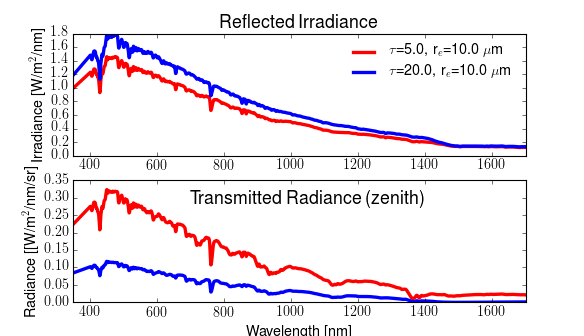

In [73]:
t1,t2 = 7,22 
r1,r2 = 8,8
fig = plt.figure()
ax1 = plt.subplot(211)
ax1.plot(lut.wvl,lut.reflect[1,:,1,r1,t1]*lut.sp_irrdn[1,:,1,r1,t1],'r',lw=3,
         label='$\\tau$={tau}, r$_e$={ref} $\\mu$m'.format(tau=lut.tau[t1],ref=lut.ref[r1]))
ax1.plot(lut.wvl,lut.reflect[1,:,1,r2,t2]*lut.sp_irrdn[1,:,1,r1,t1],'b',lw=3,
         label='$\\tau$={tau}, r$_e$={ref} $\\mu$m'.format(tau=lut.tau[t2],ref=lut.ref[r2]))

ax1.set_title('Reflected Irradiance',fontsize=16)
ax1.set_ylabel('Irradiance [W/m$^{2}$/nm]')

plt.legend(frameon=False)

ax2 = plt.subplot(212,sharex=ax1)
ax2.plot(lut.wvl,lut.sp[1,:,0,r1,t1],'r',lw=3,
         label='$\\tau$={tau}, r$_e$={ref} $\\mu$m'.format(tau=lut.tau[t1],ref=lut.ref[r1]))
ax2.plot(lut.wvl,lut.sp[1,:,0,r2,t2],'b',lw=3,
         label='$\\tau$={tau}, r$_e$={ref} $\\mu$m'.format(tau=lut.tau[t2],ref=lut.ref[r2]))

ax2.text(1050,0.8*ax2.get_ybound()[1],'Transmitted Radiance (zenith)',fontsize=16,horizontalalignment='center')
ax2.set_ylabel('Radiance [[W/m$^{2}$/nm/sr]')
ax2.set_xlabel('Wavelength [nm]')
ax2.set_xlim([350,1700])

plt.savefig(fp+'plots/Refl_Trans_spectra.png',transparent=True,dpi=600)

### Add the measurements

In [ ]:
t1,t2 = 7,22 
r1,r2 = 8,8
fig = plt.figure()
ax1 = plt.subplot(211)
ax1.plot(lut.wvl,lut.reflect[1,:,1,r1,t1]*lut.sp_irrdn[1,:,1,r1,t1],'r',lw=3,
         label='$\\tau$={tau}, r$_e$={ref} $\\mu$m'.format(tau=lut.tau[t1],ref=lut.ref[r1]))
ax1.plot(lut.wvl,lut.reflect[1,:,1,r2,t2]*lut.sp_irrdn[1,:,1,r1,t1],'b',lw=3,
         label='$\\tau$={tau}, r$_e$={ref} $\\mu$m'.format(tau=lut.tau[t2],ref=lut.ref[r2]))

ax1.set_title('Reflected Irradiance',fontsize=16)
ax1.set_ylabel('Irradiance [W/m$^{2}$/nm]')

plt.legend(frameon=False)

ax2 = plt.subplot(212,sharex=ax1)
ax2.plot(lut.wvl,lut.sp[1,:,0,r1,t1],'r',lw=3,
         label='$\\tau$={tau}, r$_e$={ref} $\\mu$m'.format(tau=lut.tau[t1],ref=lut.ref[r1]))
ax2.plot(lut.wvl,lut.sp[1,:,0,r2,t2],'b',lw=3,
         label='$\\tau$={tau}, r$_e$={ref} $\\mu$m'.format(tau=lut.tau[t2],ref=lut.ref[r2]))

ax2.text(1050,0.8*ax2.get_ybound()[1],'Transmitted Radiance (zenith)',fontsize=16,horizontalalignment='center')
ax2.set_ylabel('Radiance [[W/m$^{2}$/nm/sr]')
ax2.set_xlabel('Wavelength [nm]')
ax2.set_xlim([350,1700])

plt.savefig(fp+'plots/Refl_Trans_spectra_meas.png',transparent=True,dpi=600)

## Now plot the reflected light and transmitted light as a function of tau

<IPython.core.display.Javascript object>


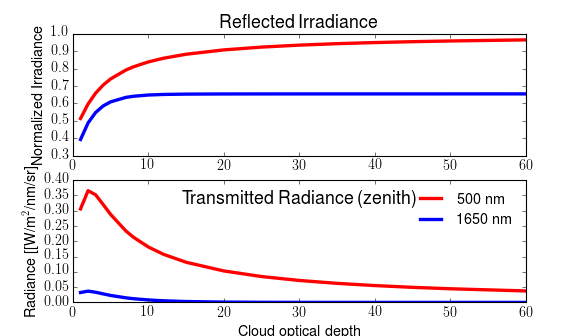

In [81]:
i500 = np.argmin(abs(lut.wvl-500.0))
i1650 = np.argmin(abs(lut.wvl-1650.0))

fig = plt.figure()
ax1 = plt.subplot(211)
ax1.plot(lut.tau,lut.reflect[1,i500,1,r1,:],'r',lw=3,
         label='{wvl:.0f} nm'.format(wvl=lut.wvl[i500]))
ax1.plot(lut.tau,lut.reflect[1,i1650,1,r2,:],'b',lw=3,
         label='{wvl:.0f} nm'.format(wvl=lut.wvl[i1650]))

ax1.set_title('Reflected Irradiance',fontsize=16)
ax1.set_ylabel('Normalized Irradiance')

ax2 = plt.subplot(212,sharex=ax1)
ax2.plot(lut.tau,lut.sp[1,i500,0,r1,:],'r',lw=3,
          label='{wvl:.0f} nm'.format(wvl=lut.wvl[i500]))
ax2.plot(lut.tau,lut.sp[1,i1650,0,r2,:],'b',lw=3,
          label='{wvl:.0f} nm'.format(wvl=lut.wvl[i1650]))

ax2.text(30,0.8*ax2.get_ybound()[1],'Transmitted Radiance (zenith)',fontsize=16,horizontalalignment='center')
ax2.set_ylabel('Radiance [[W/m$^{2}$/nm/sr]')
ax2.set_xlabel('Cloud optical depth')
ax2.set_xlim([0,60])

plt.legend(frameon=False)
plt.savefig(fp+'plots/Refl_Trans_cod.png',transparent=True,dpi=600)

## Now plot the lut of reflected and transmitted light

In [82]:
w500 = np.argmin(abs(lut.wvl-500.0))
w750 = np.argmin(abs(lut.wvl-742.0))
w1700 = np.argmin(abs(lut.wvl-1700.0))
w1650 = np.argmin(abs(lut.wvl-1650.0))
w1250 = np.argmin(abs(lut.wvl-1250.0))

<IPython.core.display.Javascript object>


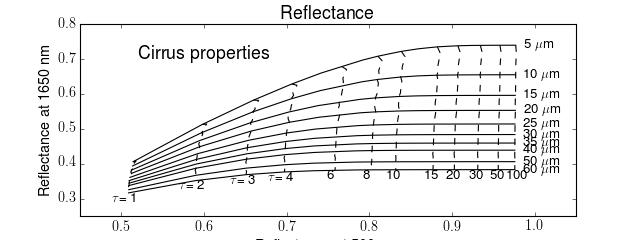

In [191]:
plt.figure(figsize=(8,3))
taus = [1,2,3,4,6,8,10,15,20,30,50,100]
refs = [1,5,10,15,20,25,30,35,40,50,60]
for ir,r in enumerate(lut.ref):
    if r in refs: 
        plt.plot(lut.reflect[1,w500,1,ir,:],lut.reflect[1,w1650,1,ir,:],'k-')
        plt.annotate('%2i $\mu$m'%r,xy=(lut.reflect[1,w500,1,ir,-1]+0.01,lut.reflect[1,w1650,1,ir,-1]-0.01))
for it,t in enumerate(lut.tau):
    if t in taus:
        plt.plot(lut.reflect[1,w500,1,:,it],lut.reflect[1,w1650,1,:,it],'k--')
        if t<6:
            plt.annotate('$\\tau$=%2i'%t,xy=(lut.reflect[1,w500,1,-1,it]-0.02,lut.reflect[1,w1650,1,-1,it]-0.025))
        else:
            plt.annotate('%2i'%t,xy=(lut.reflect[1,w500,1,-1,it]-0.01,lut.reflect[1,w1650,1,-1,it]-0.025))
plt.xlabel('Reflectance at 500 nm') 
plt.ylabel('Reflectance at 1650 nm')
plt.title('Reflectance',fontsize=16)
plt.text(0.6,0.7,'Cirrus properties', horizontalalignment='center',fontsize=16)
plt.xlim([0.45,1.05])
plt.ylim([0.25,0.8])
plt.savefig(fp+'plots/Reflectance_lut_ice_1650nm.png'.format(vv),dpi=600,transparent=True)

In [132]:
lut.trans = np.zeros_like(lut.sp)
for i in [0,1]:
    for it,t in enumerate(lut.tau):
        for ir,r in enumerate(lut.ref):
            for ip in [0,1]:
                lut.trans[i,:,ip,ir,it] = lut.sp[i,:,ip,ir,it]/lut.sp_irrdn[1,:,1,6,0]

<IPython.core.display.Javascript object>


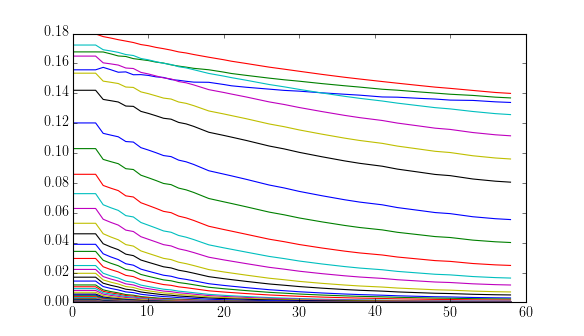

In [139]:
plt.figure()
plt.plot(lut.trans[1,w1650,0,:,:])

<IPython.core.display.Javascript object>


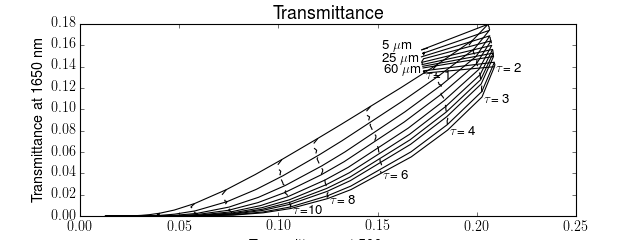

In [190]:
plt.figure(figsize=(8,3))
taus = [1,2,3,4,6,8,10,15,20,30,50,100]
refs = [5,10,15,20,25,30,35,40,50,60]
r_label = [5,25,60]
for ir,r in enumerate(lut.ref):
    if r in refs:
        plt.plot(lut.trans[1,w500,0,ir,:],lut.trans[1,w1650,0,ir,:],'k-')
        if r in r_label:
            plt.annotate('%2i $\mu$m'%r,
                         xy=(lut.trans[1,w500,0,ir,0]-0.02,lut.trans[1,w1650,0,ir,0]))
for it,t in enumerate(lut.tau):
    if t in taus:
        plt.plot(lut.trans[1,w500,0,:,it],lut.trans[1,w1650,0,:,it],'k--')
        if t<12:
            plt.annotate('$\\tau$=%2i'%t,xy=(lut.trans[1,w500,0,-1,it]+0.001,lut.trans[1,w1650,0,-1,it]-0.005))
        else:
            plt.annotate('%2i'%t,xy=(lut.trans[1,w500,0,-1,it]+0.002,lut.trans[1,w1650,0,-1,it]-0.005))
plt.xlabel('Transmittance at 500 nm') 
plt.ylabel('Transmittance at 1650 nm')
plt.title('Transmittance',fontsize=16)
#plt.text(0.6,0.7,'Cirrus properties', horizontalalignment='center',fontsize=16)
#plt.xlim([0.45,1.05])
#plt.ylim([0.25,0.8])
plt.savefig(fp+'plots/transmittance_lut_ice_1650nm.png'.format(vv),dpi=600,transparent=True)

In [164]:
lut.trans[1,w1650,0,3,0]

0.15574937390307095

## Movie of spectral changes in transmitted light and reflected light

# Now modify measurement with an uncertainty and show results

## Put on results of measured radiance and retrieved properties